In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({
    'font.family': 'serif',  # or 'sans-serif'
    'font.size': 10,         # base font size
    'axes.labelsize': 10,    # axis label size
    'axes.titlesize': 12,    # title size
    'xtick.labelsize': 8,    # x-axis tick label size
    'ytick.labelsize': 8,    # y-axis tick label size
    'legend.fontsize': 8,    # legend font size
})

DATASET_COLORS = {
    "trivia_qa_2_60k": "#000000",    # black
    "cities_10k": "#e41a1c",         # red
    "gsm8k": "#4daf4a",              # green
    "math_operations_6k": "#377eb8",  # darker yellow (gold)
    "medals_9k": "#ff7f00",          # orange
    "birth_years_4k": "#984ea3",     # purple
}
DATASET_MARKERS = {
    "trivia_qa_2_60k": "o",    # circle
    "cities_10k": "s",          # square
    "gsm8k": "D",              # diamond
    "math_operations_6k": "^",  # triangle up
    "medals_9k": "X",          # uppercase X for thicker x
    "birth_years_4k": "P",      # uppercase P for thicker plus
}

mistral_7b_cosine_directions_file = "../best_layer_finding/mistral_7b_instruct/classification_data/res_df_train_test_different_datasets_directions.parquet"
best_layer_mistral_7b = 16 # from aggregate_visualisations.ipynb


LAYER_COUNTS = dict(
    qwen_2_7b_n_layers = 28,
    qwen_32b_n_layers = 64,
    llama3_8b_n_layers = 32,
    llama3_70b_n_layers = 80,
    mistral_8b_n_layers = 36, # ministral
    mistral_7b_n_layers = 32
)

DATASET_NAME_MAP = {
    "trivia_qa_2_60k": "TriviaQA 2 60k",
    "cities_10k": "Cities 10k",
    "gsm8k": "GSM8k",
    "math_operations_6k": "Math Operations 6k",
    "medals_9k": "Medals 9k",
    "birth_years_4k": "Birth Years 4k",
}

In [13]:
# def clean_datset(df):
#     df["prompt_id_train"] = df["prompt_id_train"].str.replace("base_3_shot", "base")
#     df["prompt_id_test"] = df["prompt_id_test"].str.replace("base_3_shot", "base")
#     df = df[df["prompt_id_train"] == "base"]
#     df = df[df["prompt_id_test"] == "base"]
#     return df


In [14]:
mistral_7b_directions_df = pd.read_parquet(mistral_7b_cosine_directions_file)
mistral_7b_directions_df

,model_id_train,dataset_id_train,prompt_id_train,subset_id_train,input_type_train,layer,direction
0,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,0,"[4.029474757771822e-06, 6.620516160182887e-07,..."
1,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,2,"[-6.855938909211545e-06, 6.23058331257198e-06,..."
2,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,4,"[6.940573575775488e-06, 0.00021238350891508161..."
3,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,6,"[1.788870717973623e-05, -9.006585751194506e-05..."
4,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,8,"[-0.00020065212302142755, -7.905954553280025e-..."
...,...,...,...,...,...,...,...
91,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,22,"[0.005188555549830198, 0.015451034530997276, -..."
92,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,24,"[-0.0004150381311774254, 0.017417508363723754,..."
93,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,26,"[-0.001814055722206831, 0.029743877798318864, ..."
94,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,28,"[0.0051390358712524176, 0.04441315680742264, 0..."


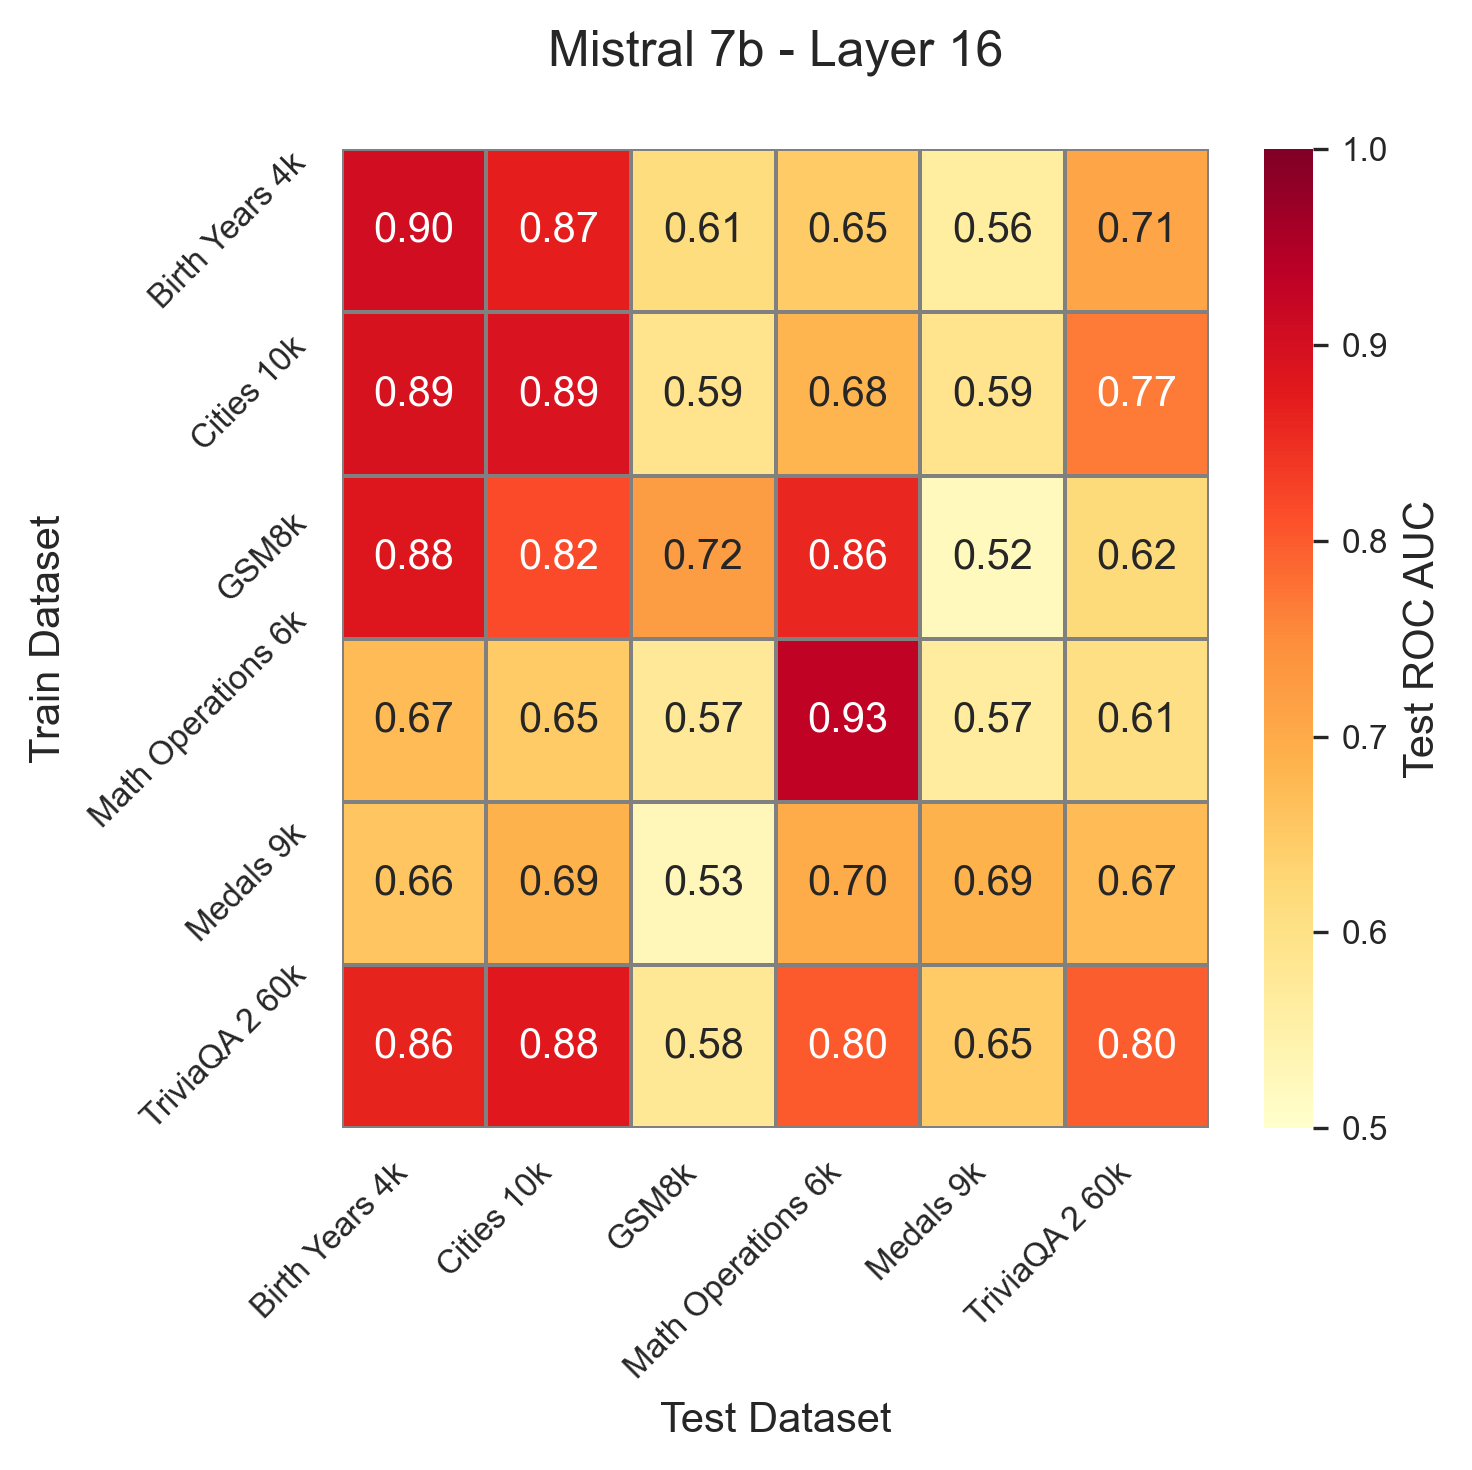

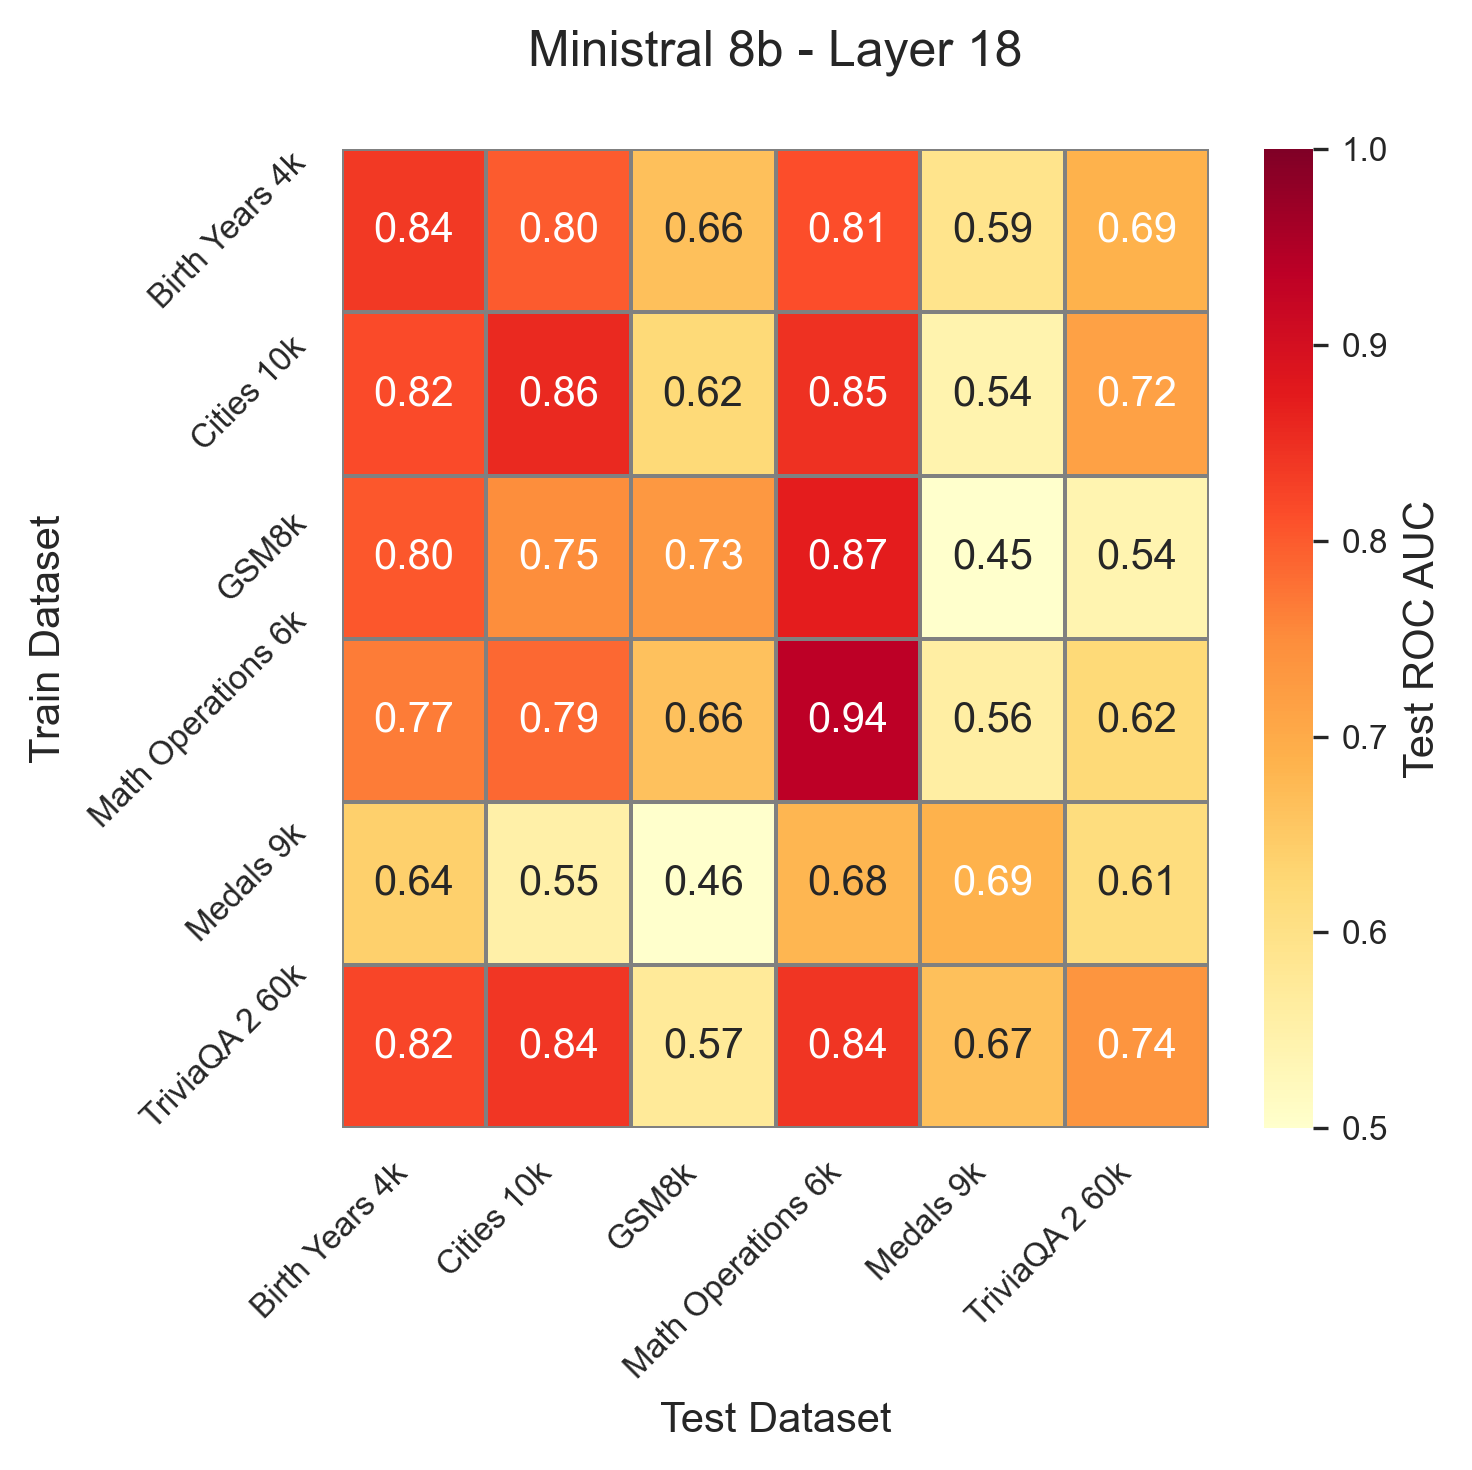

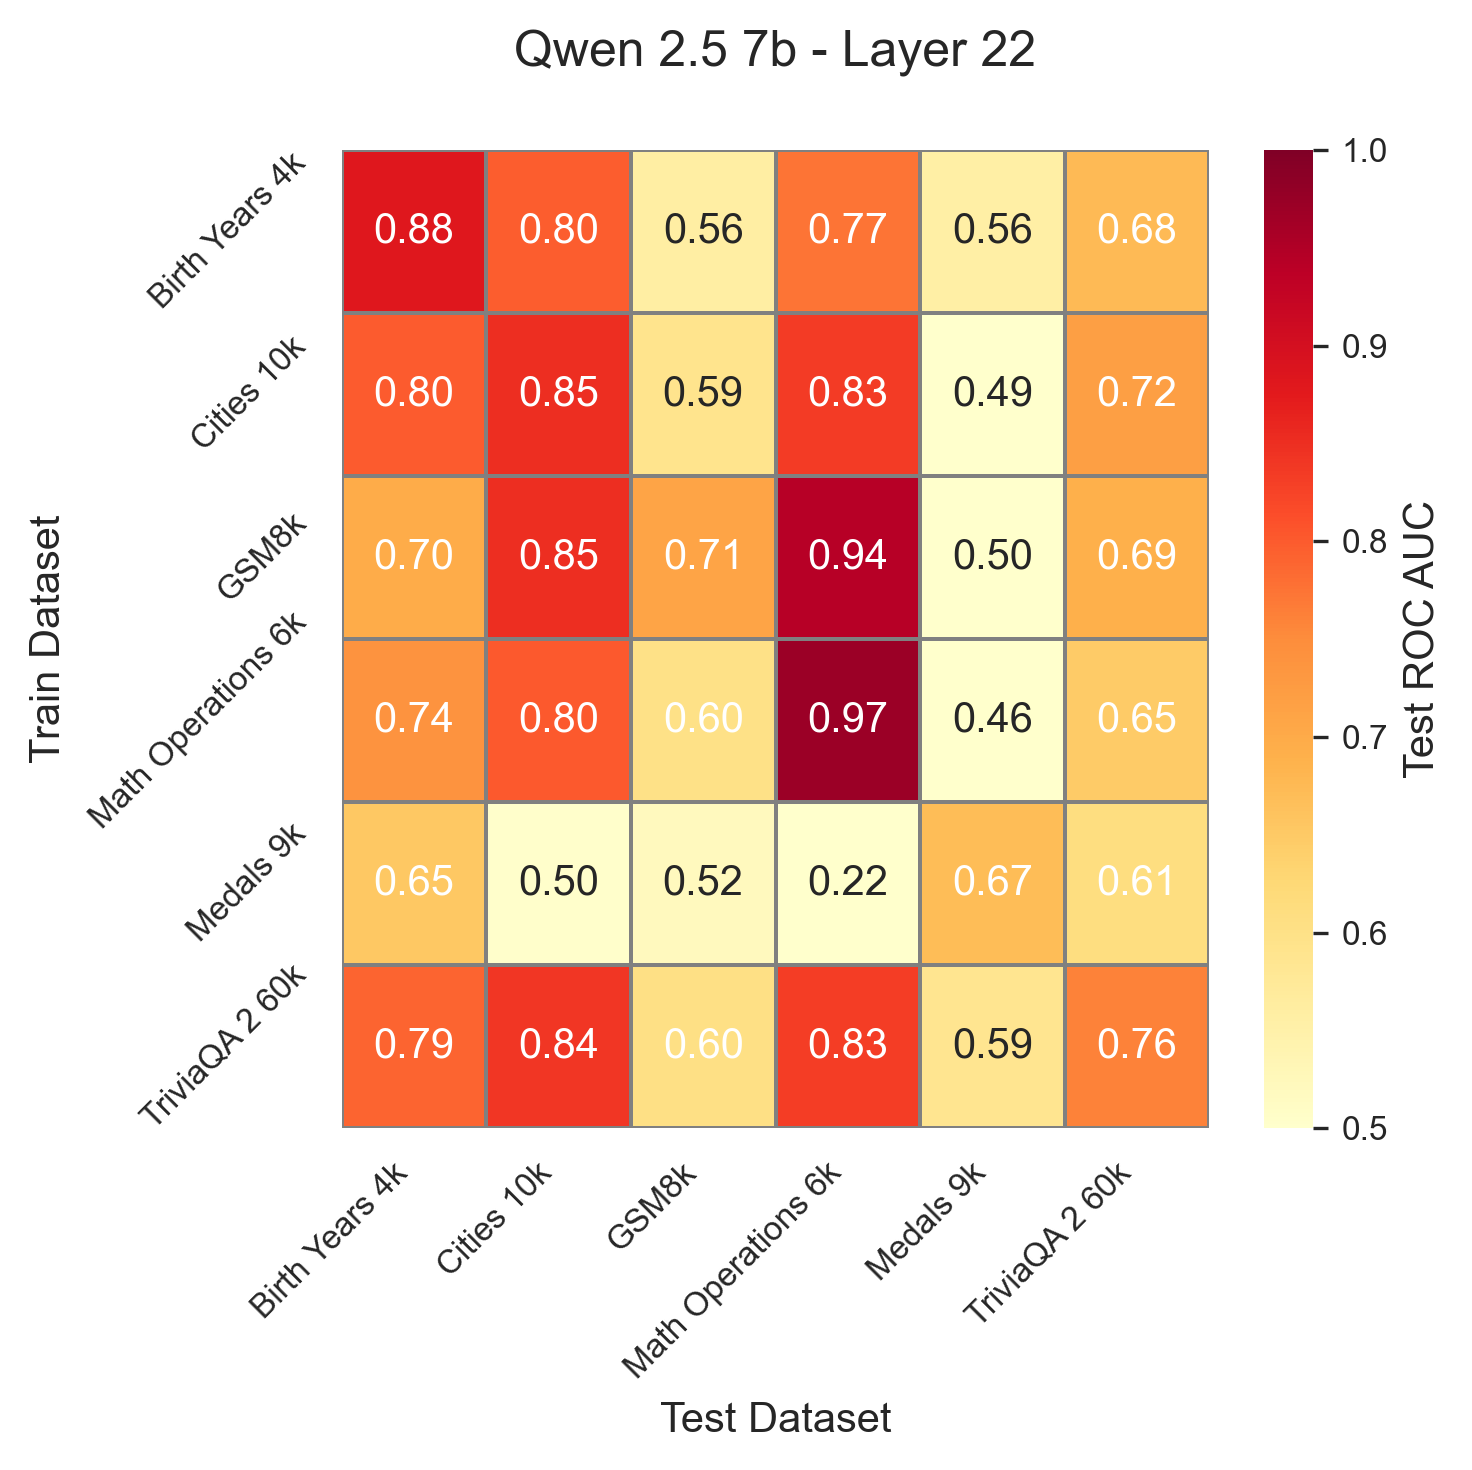

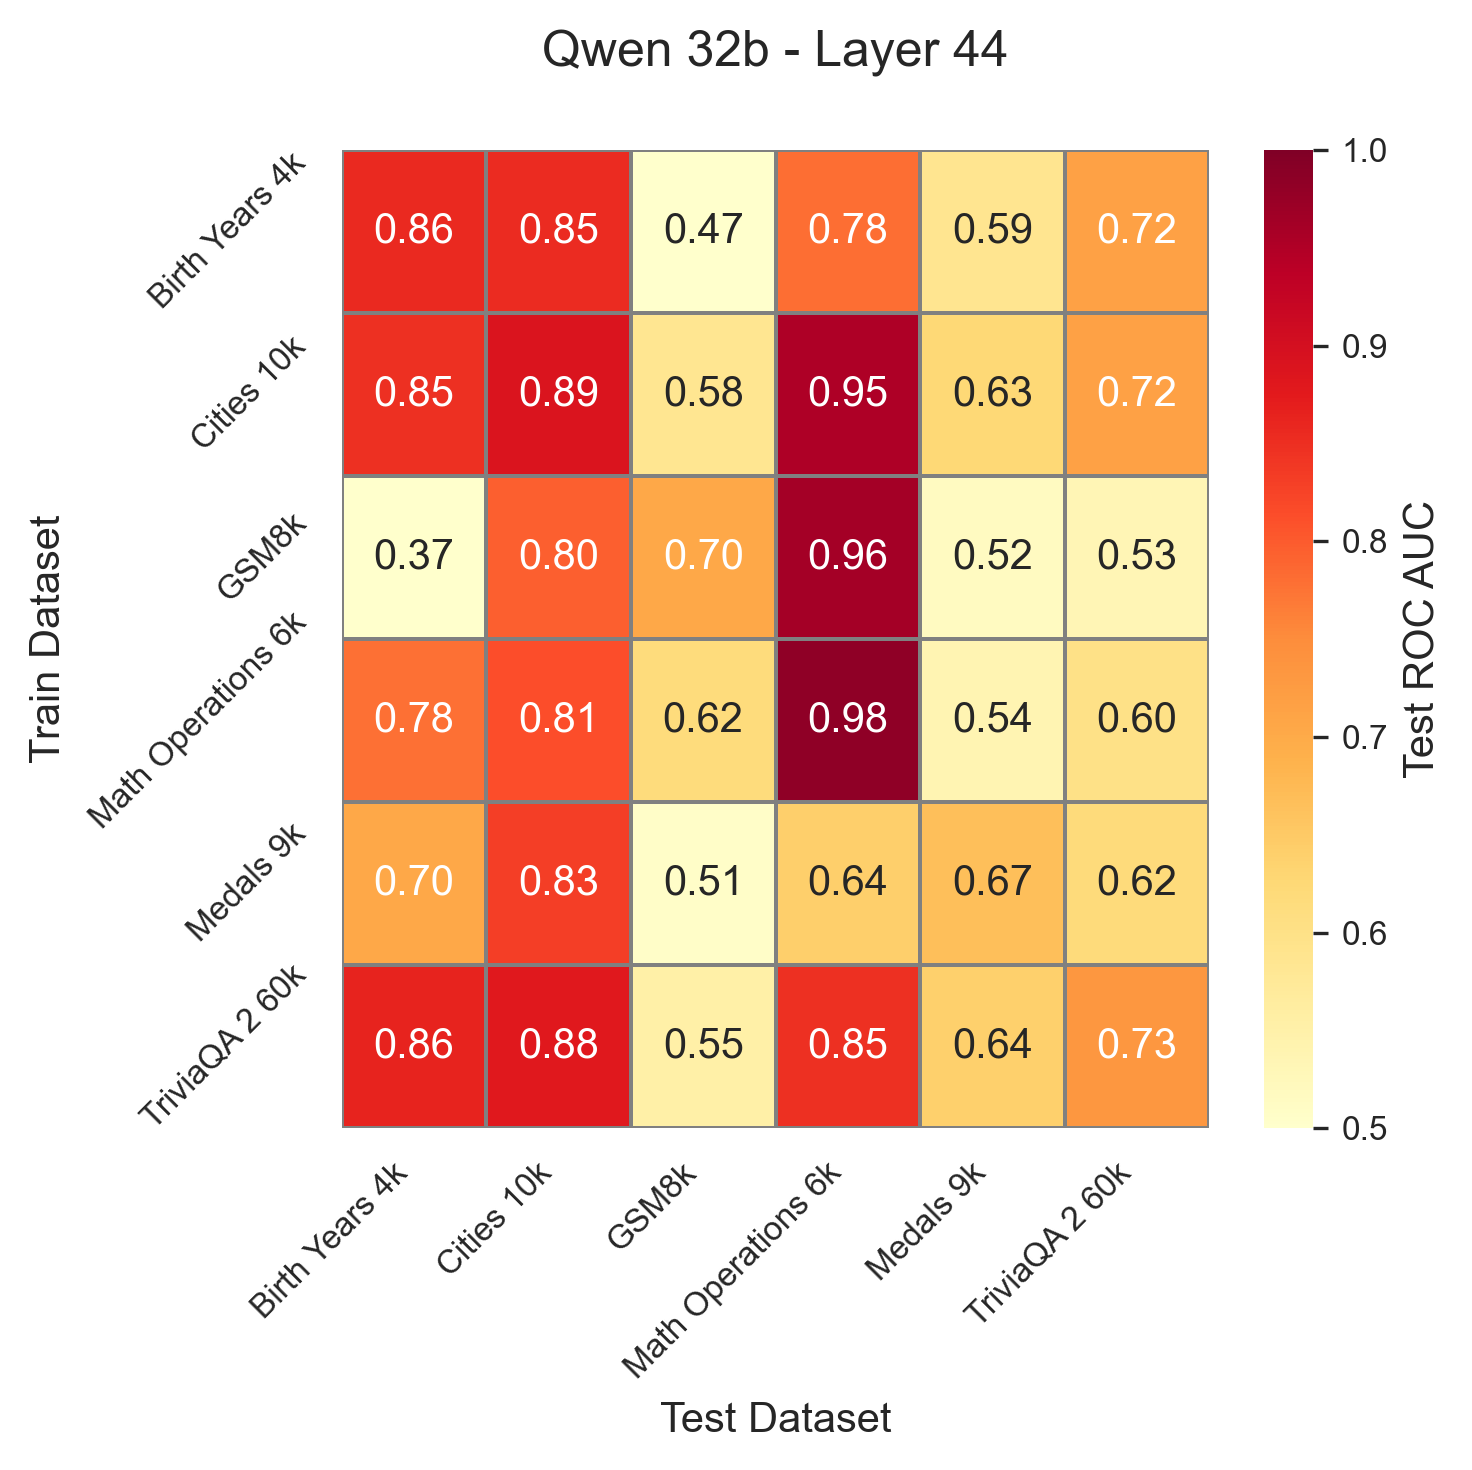

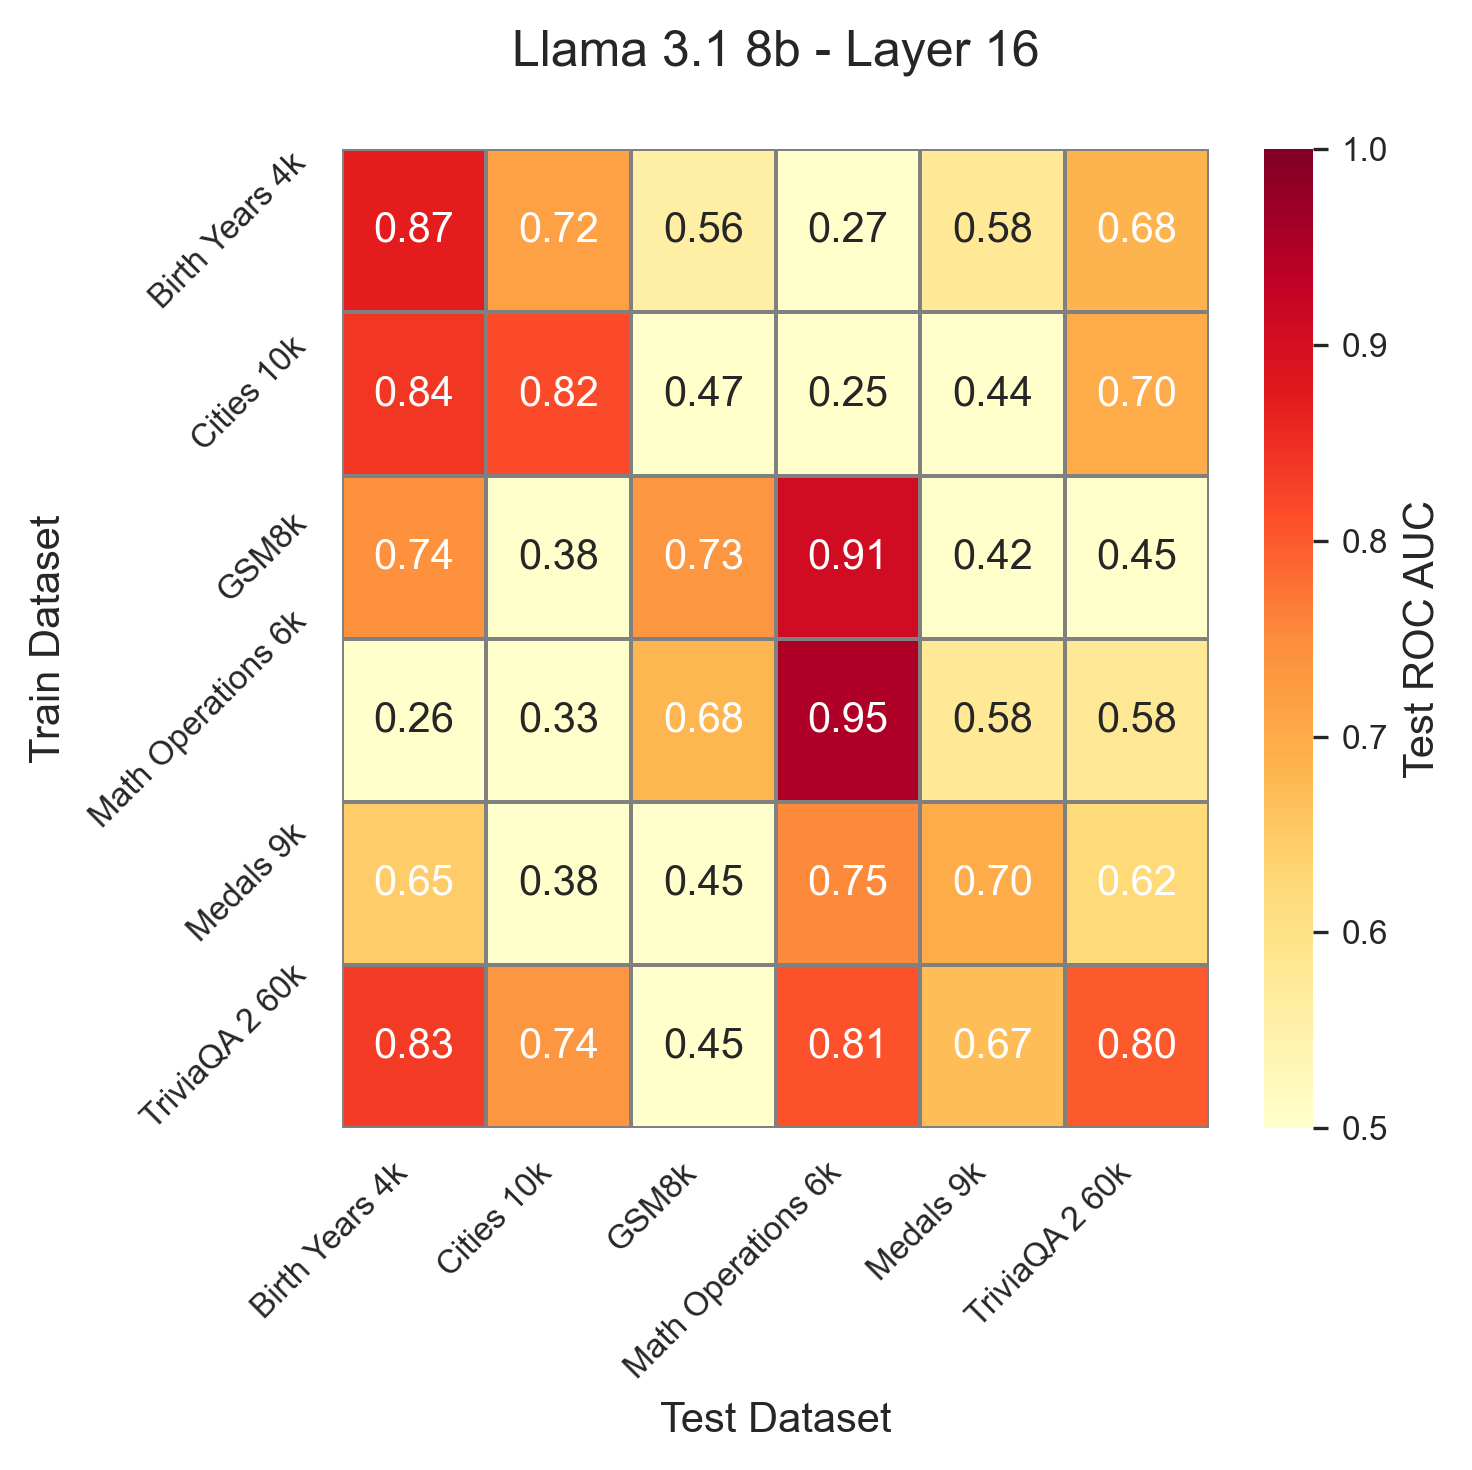

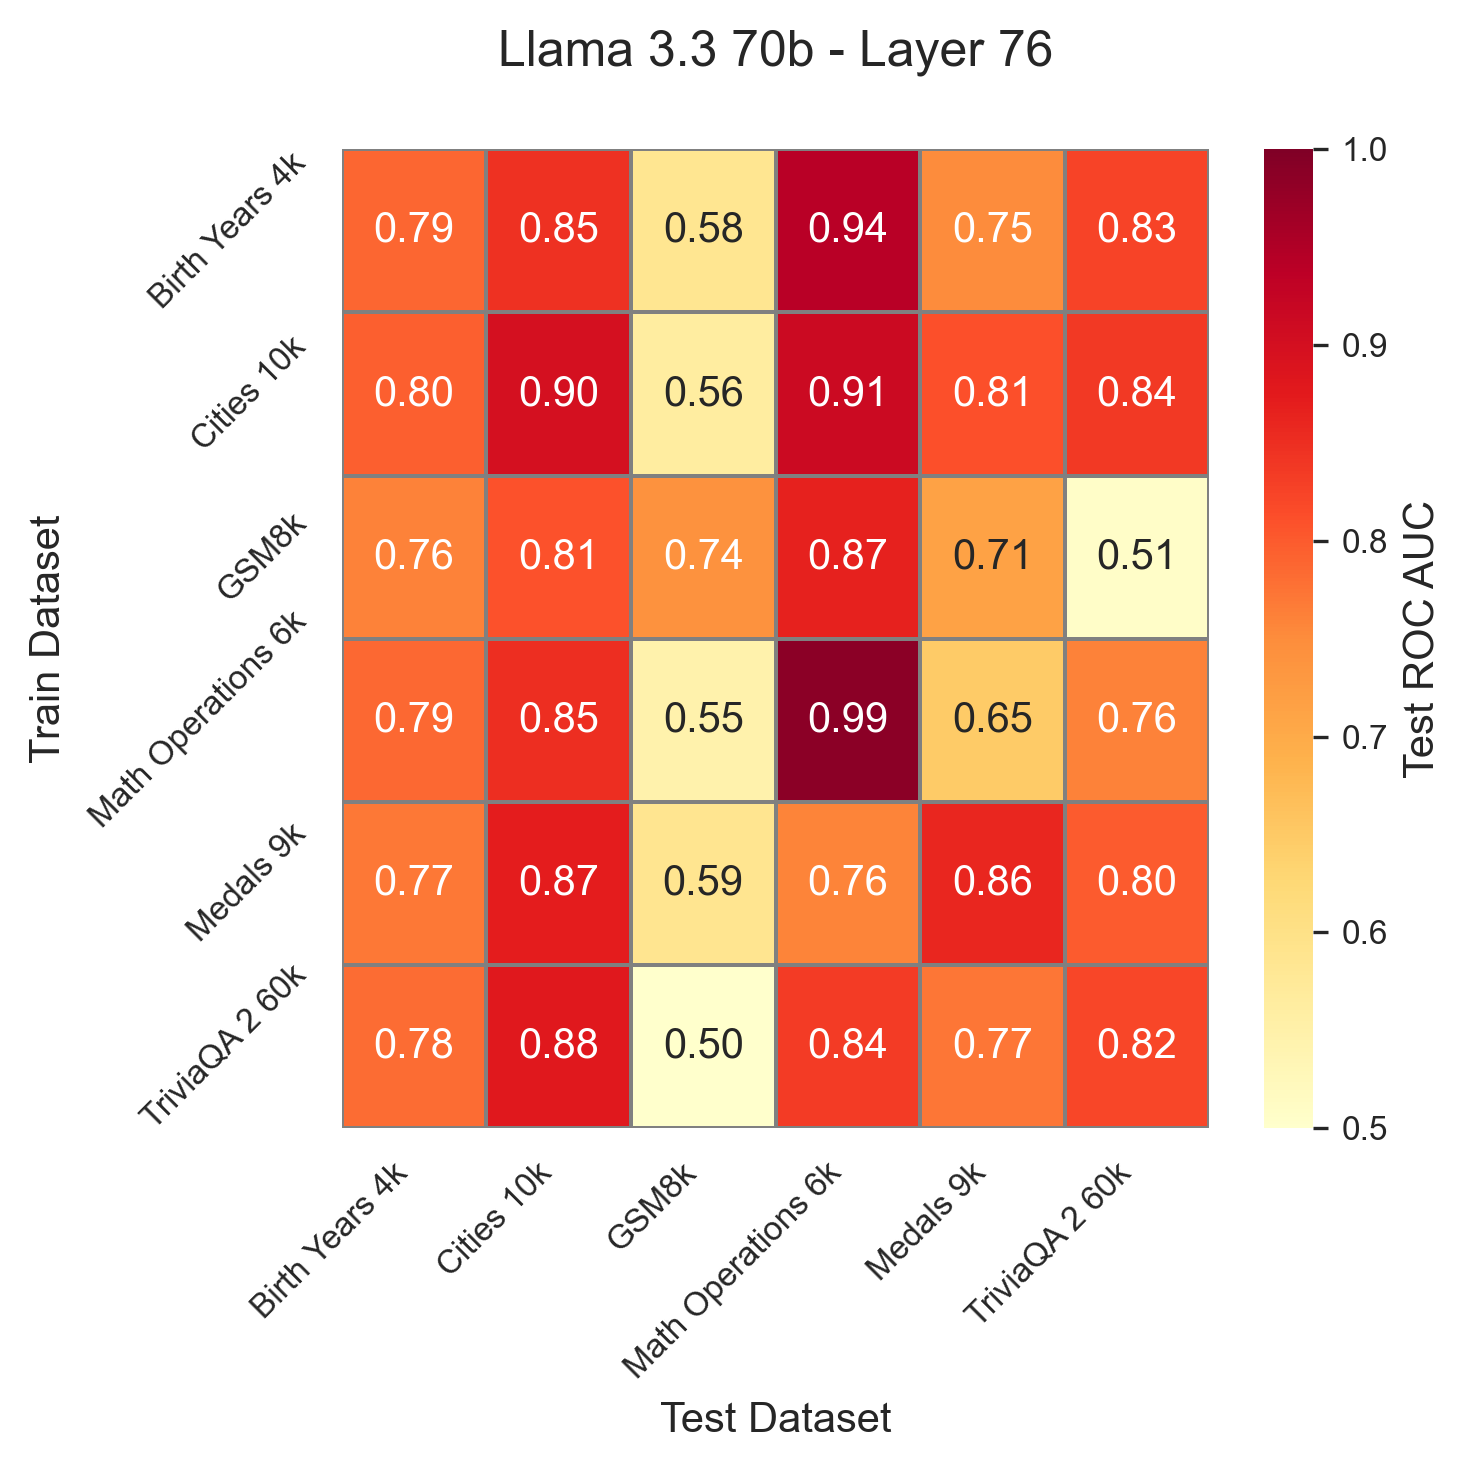

In [39]:
def heatmap_metric_across_train_test_and_dataset_combinations(model_stats_dict, metric_name, figsize=(6, 4), save_path=None):
    assert len(model_stats_dict) == 1, "Only one model is supported"
    model_name, model_dict = list(model_stats_dict.items())[0]
    stats_df = model_dict["stats_df"].copy()

    assert stats_df["input_type_train"].nunique() == 1, f"Input type train is not unique for {model_name}"
    assert stats_df["input_type_test"].nunique() == 1, f"Input type test is not unique for {model_name}"
    assert stats_df["prompt_id_train"].nunique() == 1, f"Prompt id train is not unique for {model_name}, {stats_df['prompt_id_train'].unique()=}"
    assert stats_df["prompt_id_test"].nunique() == 1, f"Prompt id test is not unique for {model_name}"

    layer = model_dict["layer"]
    stats_df = stats_df[stats_df['layer'] == layer]
    assert not stats_df.empty, f"Stats df is empty for {model_name}"

    # should have one row per fold per train dataset per test dataset
    assert len(stats_df) == stats_df["fold"].nunique() * stats_df["dataset_id_train"].nunique() * stats_df["dataset_id_test"].nunique(), f"Stats df has wrong number of rows for {model_name}"


    stats_df["model_name"] = model_name
    stats_df = stats_df[["model_name", "fold", "dataset_id_train", "dataset_id_test", metric_name]]
    stats_df_averaged = stats_df.groupby(["model_name", "dataset_id_train", "dataset_id_test"]).mean().reset_index()
    stats_df_averaged["dataset_id_train"] = stats_df_averaged["dataset_id_train"].map(DATASET_NAME_MAP)
    stats_df_averaged["dataset_id_test"] = stats_df_averaged["dataset_id_test"].map(DATASET_NAME_MAP)

    heatmap_df = stats_df_averaged.pivot(
        index="dataset_id_train",
        columns="dataset_id_test",
        values=metric_name
    )
    # ax = sns.heatmap(data=heatmap_df, annot=True)
    # ax.set_xlabel("Test Dataset")
    # ax.set_ylabel("Train Dataset")
    # ax.set_title(f"{model_name} - Layer {layer}\nTest ROC AUCs")
    # plt.tight_layout()
    # plt.show()

    plt.figure(figsize=figsize, dpi=300)
    sns.set_style("whitegrid")
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Test ROC AUC'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.gca().collections[0].set_clim(0.5, 1.0)  # Set colorbar range from 0.5 to 1.0
    plt.title(f'{model_name} - Layer {layer}', pad=20)
    plt.xlabel('Test Dataset')
    plt.ylabel('Train Dataset')
    plt.yticks(rotation=45, ha='right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save_path:
        plt.savefig(
            save_path, 
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=300
        )
    plt.show()
    

heatmap_metric_across_train_test_and_dataset_combinations(
    {
            "Mistral 7b": {"stats_df": mistral_7b_directions_df, "layer": best_layer_mistral_7b},
    },
    metric_name="direction__center_from_origin_True__classifier_cut_zero__test_roc_auc",
    figsize=(5, 5),
    # save_path=save_path
)